In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
# loading the diamond csv file for a particular company
data = pd.read_csv("/content/Diamond.csv")
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
#shape of the csv file
data.shape

(4999, 11)

data pre processing

Steps involved in Data Preprocessing

Data cleaning\
Identifying and removing outliers\
Encoding categorical variables

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4999 non-null   int64  
 1   carat       4999 non-null   float64
 2   cut         4999 non-null   object 
 3   color       4999 non-null   object 
 4   clarity     4999 non-null   object 
 5   depth       4999 non-null   float64
 6   table       4999 non-null   float64
 7   price       4999 non-null   int64  
 8   x           4999 non-null   float64
 9   y           4999 non-null   float64
 10  z           4999 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 429.7+ KB


In [ ]:
data = data.drop(["Unnamed: 0"], axis=1)
data.describe()

,carat,depth,table,price,x,y,z
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,0.765607,61.855051,57.635627,2927.437487,5.799676,5.802136,3.585833
std,0.204619,1.644960,2.351286,877.698902,0.596703,0.583709,0.384570
min,0.200000,43.000000,50.100000,326.000000,3.790000,3.750000,0.000000
25%,0.710000,61.000000,56.000000,2871.000000,5.700000,5.725000,3.520000
50%,0.760000,61.900000,57.000000,3145.000000,5.870000,5.880000,3.620000
75%,0.900000,62.700000,59.000000,3431.000000,6.140000,6.140000,3.830000
max,1.520000,71.600000,70.000000,3742.000000,7.560000,7.420000,4.800000


In [ ]:
#Dropping dimensionless diamonds and outliers
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)
data = data[(data["depth"]<75) & (data["depth"]>45)]
data = data[(data["table"]<80) & (data["table"]>40)]
data = data[(data["x"]<30)]
data = data[(data["y"]<30)]
data = data[(data["z"]<30) & (data["z"]>2)]
data.shape

(4995, 10)

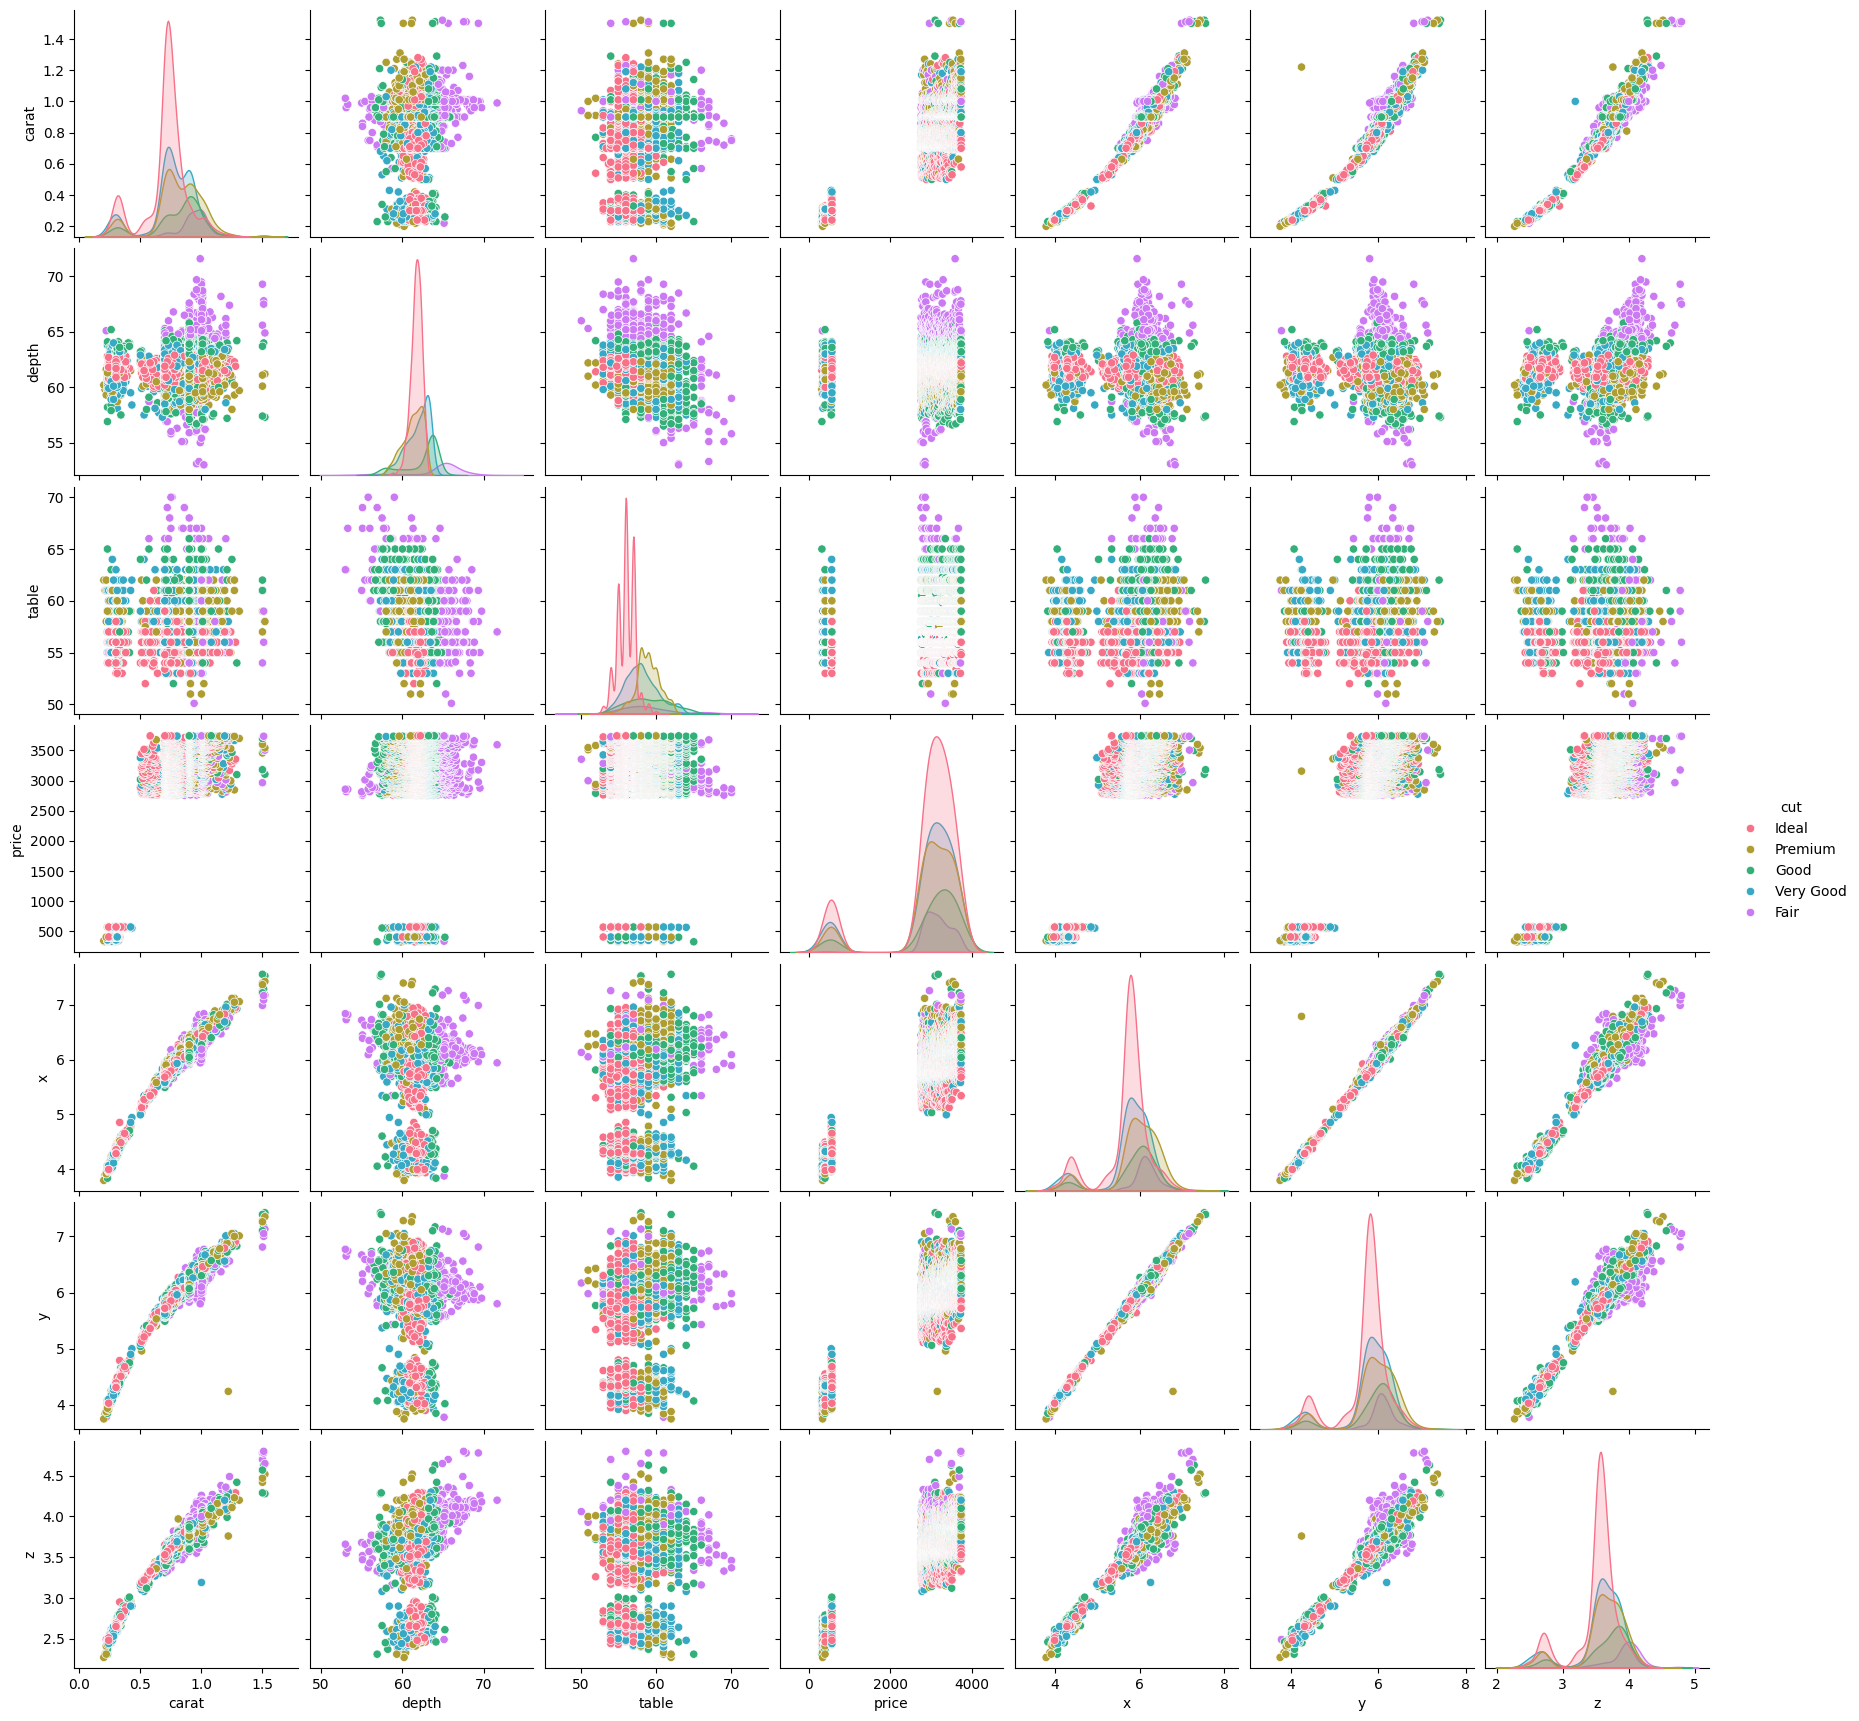

In [ ]:
# Visualizing data
shade = sns.color_palette("husl", 5)
ax = sns.pairplot(data, hue="cut", palette=shade)
plt.show()

In [ ]:
# Get list of categorical variables
s = (data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [ ]:
# Encoding categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)
label_data = data.copy()
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])

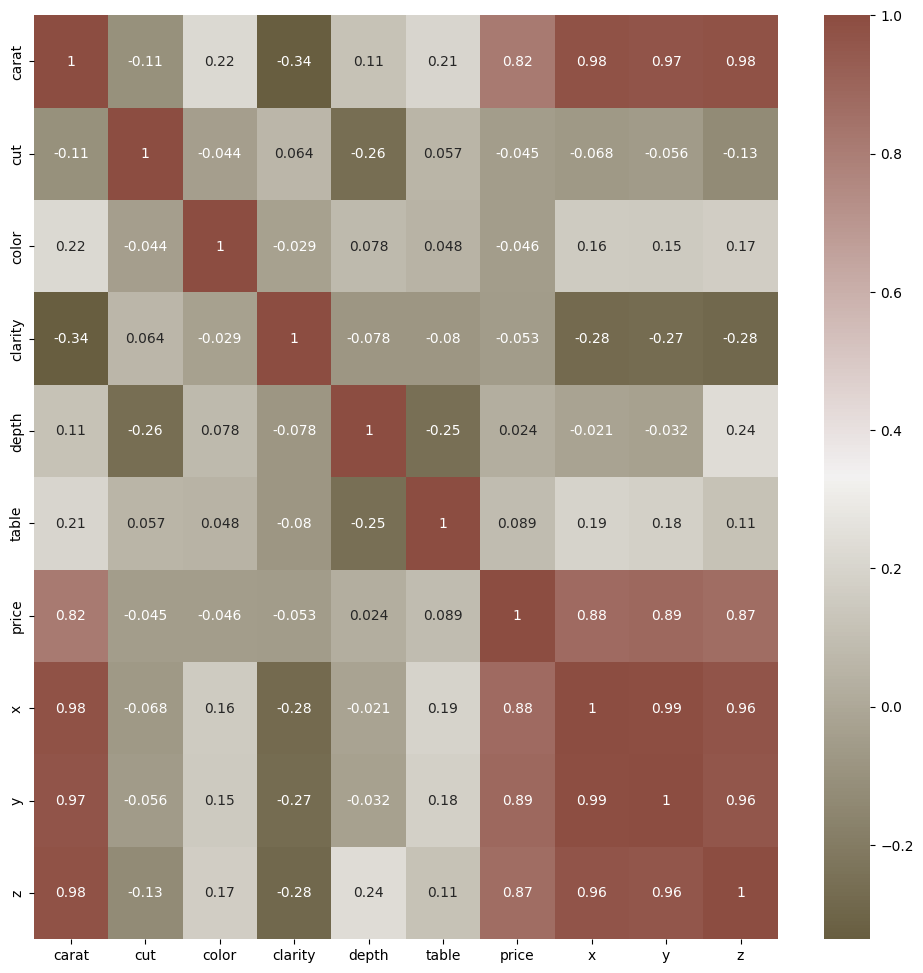

In [ ]:
# Correlation matrix
cmap = sns.diverging_palette(70, 20, s=50, l=40, n=6, as_cmap=True)
corrmat = label_data.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, cmap=cmap, annot=True)
plt.show()

In [ ]:
# OLS Regression
X = label_data.drop(["price"], axis=1)
y = label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
X_train_ols = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3218.
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:27:10   Log-Likelihood:                -26608.
No. Observations:                3746   AIC:                         5.324e+04
Df Residuals:                    3736   BIC:                         5.330e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.14e+04   1187.122     -9.602      0.0

In [ ]:
# Collinearity Check
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

   Feature          VIF
0    carat   701.698620
1      cut     6.372226
2    color     3.547396
3  clarity     7.418304
4    depth  2722.546158
5    table   736.630175
6        x  9854.490859
7        y  8730.944900
8        z  8458.599125


In [ ]:
# Pipeline setup
pipeline_lr = Pipeline([
    ("scalar1", StandardScaler()),
    ("lr_classifier", LinearRegression())
])

pipeline_dt = Pipeline([
    ("scalar2", StandardScaler()),
    ("dt_classifier", DecisionTreeRegressor())
])

pipeline_rf = Pipeline([
    ("scalar3", StandardScaler()),
    ("rf_classifier", RandomForestRegressor())
])

pipeline_kn = Pipeline([
    ("scalar4", StandardScaler()),
    ("rf_classifier", KNeighborsRegressor())
])

pipeline_xgb = Pipeline([
    ("scalar5", StandardScaler()),
    ("rf_classifier", XGBRegressor())
])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

In [ ]:
# GridSearchCV for Model Parameter Tuning
param_grid_rf = {
    'rf_classifier__n_estimators': [100, 200, 300],
    'rf_classifier__max_depth': [10, 20, 30, None],
    'rf_classifier__min_samples_split': [2, 5, 10],
    'rf_classifier__min_samples_leaf': [1, 2, 4],
    'rf_classifier__bootstrap': [True, False]
}

In [ ]:
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Parameters for RandomForestRegressor:")
print(grid_rf.best_params_)

Best Parameters for RandomForestRegressor:
{'rf_classifier__bootstrap': True, 'rf_classifier__max_depth': 30, 'rf_classifier__min_samples_leaf': 2, 'rf_classifier__min_samples_split': 10, 'rf_classifier__n_estimators': 200}


In [ ]:
# Model evaluation
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor"}

for pipe in pipelines:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -307.667859 
DecisionTree: -276.114010 
RandomForest: -202.256279 
KNeighbors: -230.084588 
XGBRegressor: -203.082685 


In [ ]:
# Model performance metrics
for i, model in enumerate(pipelines):
    pred = model.predict(X_test)
    print(f'\nFor model {pipe_dict[i]}\n')
    print("R^2:", metrics.r2_score(y_test, pred))
    print("Adjusted R^2:", 1 - (1 - metrics.r2_score(y_test, pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
    print("MAE:", metrics.mean_absolute_error(y_test, pred))
    print("MSE:", metrics.mean_squared_error(y_test, pred))
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, pred)))


For model LinearRegression

R^2: 0.8896242688432687
Adjusted R^2: 0.888822508084261
MAE: 234.90518770681535
MSE: 89507.8292854567
RMSE: 299.17859095439417

For model DecisionTree

R^2: 0.9134290598020852
Adjusted R^2: 0.9128002152001633
MAE: 187.9171337069656
MSE: 70203.62950360288
RMSE: 264.95967524059745

For model RandomForest

R^2: 0.9488090607538535
Adjusted R^2: 0.9484372137375376
MAE: 155.14039071257005
MSE: 41512.656840297044
RMSE: 203.74655049913616

For model KNeighbors

R^2: 0.933742505997358
Adjusted R^2: 0.9332612166946753
MAE: 179.19727782225783
MSE: 53730.69242594075
RMSE: 231.79881886226417

For model XGBRegressor

R^2: 0.9488896735403614
Adjusted R^2: 0.9485184120890807
MAE: 153.49600019370965
MSE: 41447.284901580526
RMSE: 203.5860626407921


In [ ]:
# Save predictions to CSV
output = pd.Series(y_pred)
output.to_csv('Final Output.csv')

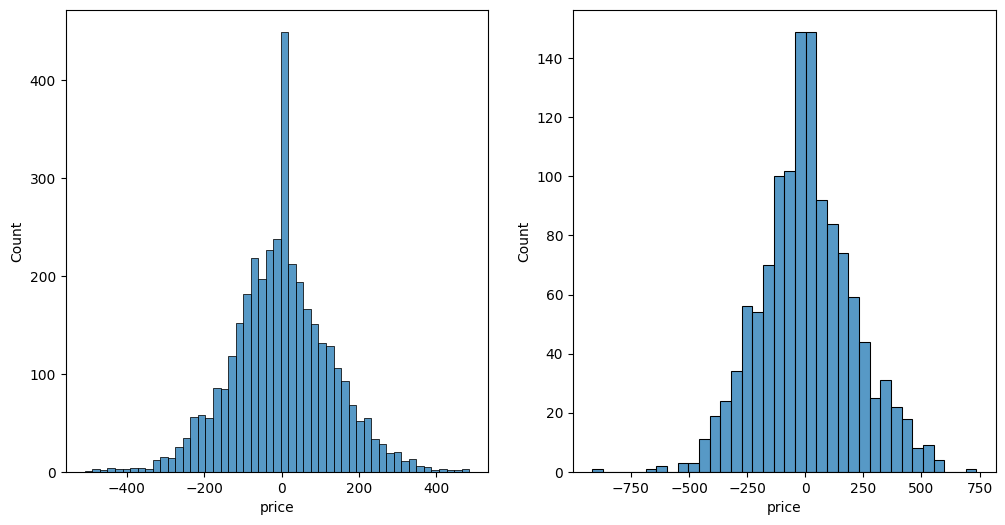

In [ ]:
y_train_pred = grid_rf.best_estimator_.predict(X_train)
y_test_pred = grid_rf.best_estimator_.predict(X_test)

train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(train_residuals, ax=ax[0])
sns.histplot(test_residuals, ax=ax[1])
plt.show()

In [ ]:
rf_feature_importances = grid_rf.best_estimator_.named_steps['rf_classifier'].feature_importances_

In [ ]:
rf_feature_importances = grid_rf.best_estimator_.named_steps['rf_classifier'].feature_importances_

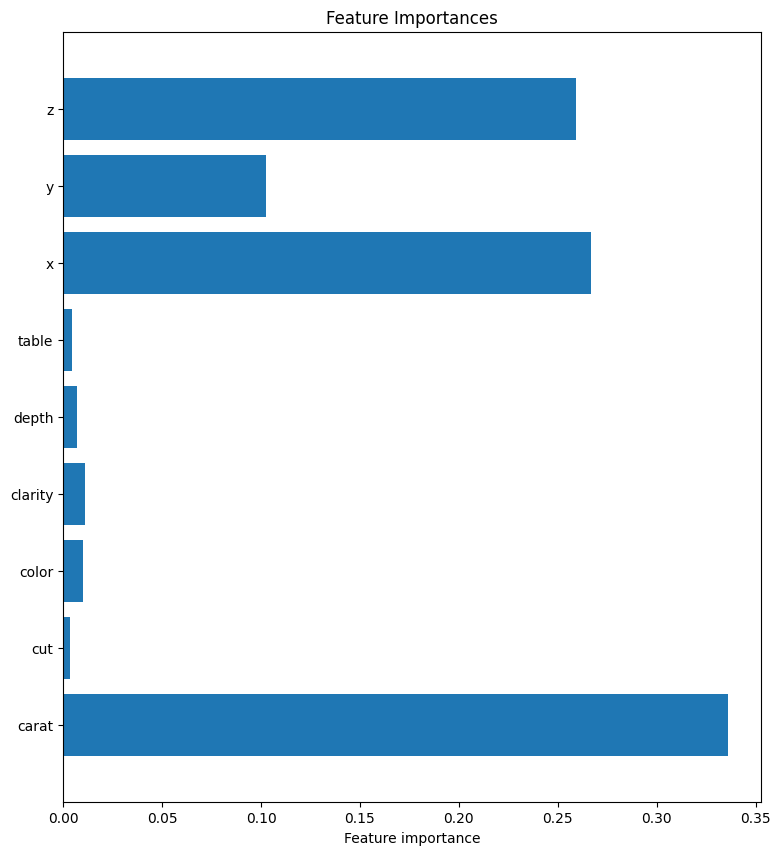

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importances(model, feature_names):
    n_features = len(feature_names)
    plt.figure(figsize=(n_features, 10))
    plt.barh(range(n_features), rf_feature_importances, align='center')
    plt.yticks(range(n_features), feature_names)
    plt.xlabel('Feature importance')
    plt.ylim(-1, n_features)
    plt.title('Feature Importances')

# Extract feature importances from the best model
rf_feature_importances = grid_rf.best_estimator_.named_steps['rf_classifier'].feature_importances_

# Get feature names from the original data
feature_names = X.columns

# Create feature importance plot
plot_feature_importances(grid_rf.best_estimator_, feature_names)
plt.show()